# LangGraphサンプルコード
* 『LangChainとLangGraphによるRAG・AIエージェント実践入門』より

In [1]:
# !pip install langchain==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22

In [10]:
# import os

# os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
# os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT

In [9]:
from dotenv import load_dotenv
load_dotenv()

## ロール定義
* 今回のアプリでは、回答を生成する前に、回答を担当するためのロールを選択する処理が入る。ここであらかじめ定義したロールをLLMに選択させるようにする。

In [11]:
### ロール定義
ROLES = {
    "1": {
        "name": "一般知識エキスパート",
        "description": "幅広い分野の一般的な質問に答える",
        "details": "幅広い分野の一般的な質問に対して、正確でわかりやすい回答を提供してください。"
    },
    "2": {
        "name": "生成AIエキスパート",
        "description": "生成AIや関連製品、技術に関する専門的な質問に答える",
        "details": "生成AIや関連製品、技術に関する専門的な質問に対して、最新の情報と深い洞察を提供してください。"
    },
    "3": {
        "name": "カウンセラー",
        "description": "個人的な悩みや心理的な問題に対してサポートを提供する",
        "details": "個人的な悩みや心理的な問題に対して、共感的で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください。"
    }
}

## ステートの定義
* アプリのステートを表現するStateクラスを定義

In [12]:
import operator
from typing import Annotated

from langchain_core.pydantic_v1 import BaseModel, Field

class State(BaseModel):
    query: str = Field(
        ..., description="ユーザーからの質問"
    ) # `...`で必須を表す
    current_role: str = Field(
        default="", description="選定された回答ロール"
    )
    messages: Annotated[list[str], operator.add] = Field(
        default=[], description="回答履歴"
    ) # operator.addで、リストに新しい情報を追加できることを示す
    current_judge: bool = Field(
        default=False, description="品質チェックの結果"
    )
    judgement_reason: str = Field(
        default="", description="品質チェックの判定理由"
    )

## Chat modelの初期化
* ノードの実装で利用するチャットモデルを初期化する。

In [13]:
from langchain_openai import ChatOpenAI
from langchain_core.runnables import ConfigurableField

llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
# 後からmax_tokensの値を変更できるように、変更可能なフィールドを宣言
llm = llm.configurable_fields(max_tokens=ConfigurableField(id='max_tokens'))

## ノードの定義
* グラフの各ノードを関数として定義する。各ノードは現在のステートを受け取り、ステートの更新差分を辞書型で返す。

### selectionノードの実装
* 回答ロールの選定を行うselectionノードでは、各ロールに対応する番号のみをLLMに応答させるプロンプトを設定している。LLMによる処理の後、番号に対応するロール名をステートに設定する。

In [14]:
from typing import Any

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def selection_node(state: State) -> dict[str, Any]:
    """
    ユーザーからの質問に対するロールを選択するLLM関数
    """
    query = state.query

    role_options ="\n".join([f"{k}.{v['name']}: {v['description']}" for k, v in ROLES.items()]) # ROLEの中身をすべて文字列化

    prompt = ChatPromptTemplate.from_template(
        """
    質問を分析し、最も適切な回答担当ロールを選択してください。

    選択肢：
    {role_options}

    回答は選択肢の番号（１，２，または３）のみを返してください。

    質問：{query}
    """.strip()
    )

    # 選択肢の番号のみを返すことを期待したいため、max_tokensの値を１に変更
    chain = prompt | llm.with_config(configurable=dict(max_tokens=1)) | StrOutputParser()
    role_number = chain.invoke({"role_options": role_options, "query": query})

    # 選択されたロール番号に対する"name"要素を取得
    selected_role = ROLES[role_number.strip()]["name"]

    return {"current_role": selected_role}

### answeringノードの実装
* 選定されたロールに基づいて回答を行うansweringノードでは、ロールに基づいた回答を提供するようにプロンプトを設定
* LLMによる処理の後、応答をmessagesリストに追加している

In [16]:
def answering_node(state: State) -> dict[str, Any]:
    """
    選定されたロールに基づいて回答を行うLLM関数
    """
    query = state.query

    role = state.current_role

    role_details = "\n".join([f"- {v['name']}: {v['details']}" for v in ROLES.values()]) # name: detailsで、すべてのname: detailsを文字列化
    # 上記role_detailsですべての役割を説明する文章と、roleを渡すことで、対象roleがどんな処理を行うかをLLMが理解できるようになる

    prompt = ChatPromptTemplate.from_template(
        """
        あなたは{role}として回答してください。以下の質問に対して、あなたの役割に基づいた適切な回答を提供してください。

        役割の詳細：
        {role_details}

        質問：{query}

        回答：""".strip()
    )
    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"role": role, "role_details": role_details, "query": query})

    return {"messages": [answer]}

### checkノードの実装
* 最後に回答の品質をチェックするcheckノードでは、ユーザーの質問と回答の内容をもとに品質チェックを行うプロンプトを設定する。
* Chat modelにwith_structured_outputを指定することで、生成結果の内容が1Judgementモデルの内容として返却されるように指示する。

In [17]:
class Judgement(BaseModel):
    reason: str = Field(default="", description="判定理由")
    judge: bool = Field(default=False, description="判定結果")

def check__node(state: State) -> dict[str, Any]:
    query = state.query
    answer = state.messages[-1]
    prompt = ChatPromptTemplate.from_template(
        """
        以下の回答の品質をチェックし、問題がある場合は'False'、問題がない場合は'True'を回答してください。
        また、その判断理由も説明してください。

        ユーザーからの質問：{query}
        回答：{answer}
        """.strip()
    )
    chain = prompt | llm.with_structured_output(Judgement)
    result: Judgement = chain.invoke({"query": query, "answer": answer})

    return {
        "current_judge": result.judge,
        "judgement_reason": result.reason
        }

## グラフの作成
* StateGraphクラスを使用してグラフのインスタンスを作成
* Azureでスレッドを設定するときに、スレッドの初期状態として、各種変数の初期値をセットしたが、それと同じような処理

In [18]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)

## ノードの追加
* `add_node`関数を使用して`selection`ノード、`answering`ノード、`check`ノードを追加する。
* それぞれの第１引数にはノード名を記載し、第２引数にはノードの定義で作成した関数を紐づける。

In [19]:
workflow.add_node("selection", selection_node)
workflow.add_node("answering", answering_node)
workflow.add_node("check", check__node)

## エッジの定義
* ワークフローには出発点となるノードをエッジで指定する必要がある。
* 出発点となるノードは`set_entry_point`関数で定義する。

In [20]:
# selectionノードから処理を開始
workflow.set_entry_point("selection")

* 次に、どのノード同士が接続されているかを定義する。
* `add_edge`関数を用いる。

In [21]:
# selectionノードからansweringノードへ
workflow.add_edge("selection", "answering")

# answeringノードからcheckノードへ
workflow.add_edge("answering", "check")

## 条件付きエッジの定義
* 条件分岐を含むエッジを定義する場合は、条件付きエッジを利用する。
* 定義には、`add_conditional_edges`関数を用いる。
* 今回は、品質チェックで真（True）を返した場合のみ、処理を終了するように条件付けをするため、第２引数でステートの`current_judge`の値によって条件分岐させる。current_judgeの値がTrueの場合は組み込みで終点ノードとして定義されている`END`に遷移し、Falseの場合は、`selection`ノードに遷移するよう、第３引数において辞書型で指定する。

In [22]:
from langgraph.graph import END

# checkノードから次のノードへの遷移に条件付きエッジを定義
# state.current_judgeの値がTrueならENDノードへ、Falseならselectionノードへ遷移
workflow.add_conditional_edges(
    "check",
    lambda state: state.current_judge,
    {True: END, False: "selection"}
)

## グラフのコンパイル
* グラフの定義が完了したら、`compile`関数を実行し、`CompiledGraph`クラスのインスタンスに変換する

In [23]:
compiled = workflow.compile()

## グラフの実行
* 処理の実行時、処理の引数には初期のステートを設定する。（質問文をStateにセットするだけ）

In [24]:
initial_state = State(query="生成AIについて教えてください")
result = compiled.invoke(initial_state)

In [25]:
result

{'query': '生成AIについて教えてください',
 'current_role': '生成AIエキスパート',
 'messages': ['生成AIエキスパートとしてお答えします。\n\n生成AI（生成的人工知能）は、人工知能の一分野であり、新しいデータやコンテンツを生成する能力を持つモデルを指します。これには、テキスト、画像、音声、音楽など、さまざまな形式のコンテンツが含まれます。生成AIの代表的な技術には、以下のようなものがあります。\n\n1. **自然言語処理（NLP）モデル**: 例えば、GPT（Generative Pre-trained Transformer）シリーズは、テキストの生成や翻訳、要約などに用いられます。これらのモデルは、大量のテキストデータを学習し、人間のように自然な文章を生成することができます。\n\n2. **画像生成モデル**: GAN（Generative Adversarial Networks）やVAE（Variational Autoencoders）などの技術を用いて、新しい画像を生成します。これにより、アート作品の創作や、現実には存在しない人物の顔を生成することが可能です。\n\n3. **音声合成**: TTS（Text-to-Speech）技術を用いて、テキストから自然な音声を生成します。これにより、音声アシスタントやナレーションの自動生成が可能になります。\n\n生成AIは、クリエイティブな分野での応用が進んでおり、映画や音楽、広告などでの活用が期待されています。また、教育や医療などの分野でも、個別化されたコンテンツの提供に役立つ可能性があります。しかし、生成AIの利用には倫理的な課題も伴い、フェイクニュースの生成や著作権の問題などが議論されています。\n\nこの分野は急速に進化しており、今後も新しい技術や応用が登場することが予想されます。'],
 'current_judge': True,
 'judgement_reason': '回答は生成AIについての基本的な情報を網羅しており、自然言語処理、画像生成、音声合成などの具体的な技術例を挙げて説明しています。また、生成AIの応用分野や倫理的な課題についても触れており、ユーザーに対して包括的な理解を提供しています。特に問題となる誤りや不正確な情報は含

In [26]:
print(result['messages'][-1])

生成AIエキスパートとしてお答えします。

生成AI（生成的人工知能）は、人工知能の一分野であり、新しいデータやコンテンツを生成する能力を持つモデルを指します。これには、テキスト、画像、音声、音楽など、さまざまな形式のコンテンツが含まれます。生成AIの代表的な技術には、以下のようなものがあります。

1. **自然言語処理（NLP）モデル**: 例えば、GPT（Generative Pre-trained Transformer）シリーズは、テキストの生成や翻訳、要約などに用いられます。これらのモデルは、大量のテキストデータを学習し、人間のように自然な文章を生成することができます。

2. **画像生成モデル**: GAN（Generative Adversarial Networks）やVAE（Variational Autoencoders）などの技術を用いて、新しい画像を生成します。これにより、アート作品の創作や、現実には存在しない人物の顔を生成することが可能です。

3. **音声合成**: TTS（Text-to-Speech）技術を用いて、テキストから自然な音声を生成します。これにより、音声アシスタントやナレーションの自動生成が可能になります。

生成AIは、クリエイティブな分野での応用が進んでおり、映画や音楽、広告などでの活用が期待されています。また、教育や医療などの分野でも、個別化されたコンテンツの提供に役立つ可能性があります。しかし、生成AIの利用には倫理的な課題も伴い、フェイクニュースの生成や著作権の問題などが議論されています。

この分野は急速に進化しており、今後も新しい技術や応用が登場することが予想されます。


## グラフ構造をビジュアライズして表示する

In [1]:
# !apt-get install graphviz libgraphviz-dev pkg-config
# !pip install pygraphviz

* `compile`関数を実行して得られた`CompiledGraph`クラスのインスタンスの`get_graph`関数を利用することで、グラフの構造情報を取得でき、さらに`draw_png`関数でグラフ構造をPNG画像として取得できる。

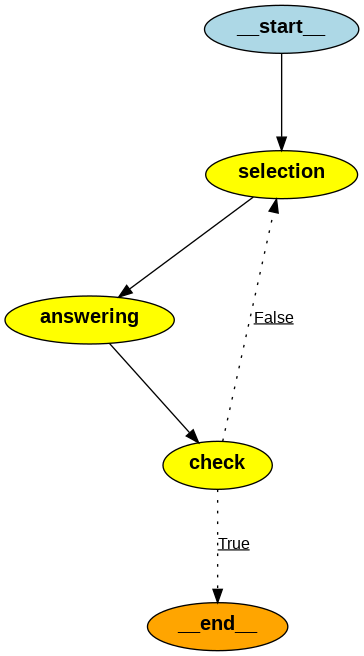

In [29]:
from IPython.display import Image

Image(compiled.get_graph().draw_png())